# Lab 6: Random Forest Regression on Malagasy Mammal Traits

Author: Eva Newby

### Introduction
 In Lab 5, we used functional trait data on bird species to predict their presence in a given climate type. This week we are using regression tree models on a similar dataset, this one on mammal species.  Our goal is to predict the total number of climate types each mammal species inhabits.

You will compare performance of a single decision tree with a tuned random forest to get a sense of the effectiveness of ensemble methods with optimized hyperparameter values.

There is a fair amount of missing data in this set, which can lead to low reliability of feature splits, increased overfitting, and decreased accuracy of tree models. You will address this issue with a combination of variable omission and imputation.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

### Step 1: Read data and retain a subset of the columns
Similar to last week, we will need to take some steps to get the data in a usable form. We again reformat the diet-related variable names to match this set: `Diet_Vertebrates`,
    `Diet_Fruits`, `Diet_Flowers`, `Diet_Seeds`, `Diet_Plants`, `Diet_Other`. Then drop columns that are not relevant functional traits or climate type variables.   Next, drop any remaining  variables that have greater than 40% of the observations missing. Print the final dataframe shape. 

In [2]:
# read-in data
data = pd.read_csv("/courses/EDS232/Data/MamTraitData.csv", encoding="ISO-8859-1").rename(columns={
    'Diet: invertebrates': 'Diet_Invertebrates',
    'Diet: vertebrates': 'Diet_Vertebrates',
    'Diet: fruits': 'Diet_Fruits',
    'Diet: flower/nectar/pollen/gums': 'Diet_Flowers',
    'Diet: seeds': 'Diet_Seeds',
    'Diet: other plant materials': 'Diet_Plants',
    'Diet: scavenge; garbage; carrion; carcasses': 'Diet_Other'
})

# Get column names
print(data.columns)

# Keep only certain columns
cols_keep = ['Diet_Invertebrates', 'Diet_Vertebrates', 'Diet_Fruits', 'Diet_Flowers', 'Diet_Seeds', 'Diet_Plants', 'Diet_Other', 
            'AdultBodyMass','Dry', 'Humid', 'Montane', 'Subarid', 'Subhumid']
data = data[cols_keep]

# drop columns with more than 40% missing values
# Caluclate percentage of missing values
percent_missing = data.isnull().mean()

# ID cols with > 40% NAs
cols_drop = percent_missing[percent_missing > 0.4].index

# Drop
data = data.drop(columns = cols_drop)


print(f"Final DataFrame shape: {data.shape}")

Index(['AdultBodyMass', 'CranialCapacity', 'Diet_Invertebrates',
       'Diet_Vertebrates', 'Diet_Fruits', 'Diet_Flowers', 'Diet_Seeds',
       'Diet_Plants', 'Diet_Other', 'HabitatBreadth', 'ActivityCycle',
       'ForagingStratum', 'GestationLength', 'LitterSize',
       'InterbirthInterval', 'HomeRange', 'PopulationDensity', 'SocialGrpSize',
       'Longevity', 'Dry', 'Humid', 'Montane', 'Subarid', 'Subhumid'],
      dtype='object')
Final DataFrame shape: (214, 13)


### Step 2: Imputation with KNN
Now impute the values of the missing data in the remaining numeric columns using k-nearest neighbors with `KNNImputer()`. Use the 5 nearest neighbors. This allows us to implement the knn algorithm to predict the missing values for an observation based on similar complete observations.Perform and print a check to ensure that there are no more NA values. 

In [3]:
# KNNImputer with 5 nearest neighbors
imputer = KNNImputer(n_neighbors = 5)

# Add to numeric colummns
cols_numeric = data.select_dtypes(include=[np.number]).columns
data[cols_numeric] = imputer.fit_transform(data[cols_numeric])

# Check missing values
missing_values = data.isnull().sum().sum()

# Print missing values
if missing_values == 0:
    print("No missing values remain after KNN imputation")
else:
    print(f"Warning: {missing_values} missing values still present")


No missing values remain after KNN imputation


### Step 3: Create target variable and numerical encoding 
Create the target variable (`nClimates`) representing the  number of climates in which a species was present. Then finish preparing the data to be used in our models.

- Create a new column `nClimates` that combines the information of the five climate type variables
- Drop the original `Dry`, `Humid`, `Montane`, `Subarid`, and `Subhumid` columns
- Encode categorical variables
- Split the dataset into training and test sets. Use a random state of 808. 

In [4]:
# Check column names
data.columns

Index(['Diet_Invertebrates', 'Diet_Vertebrates', 'Diet_Fruits', 'Diet_Flowers',
       'Diet_Seeds', 'Diet_Plants', 'Diet_Other', 'AdultBodyMass', 'Dry',
       'Humid', 'Montane', 'Subarid', 'Subhumid'],
      dtype='object')

In [5]:
# create new column
data['nClimates'] = data[['Dry', 'Humid', 'Montane', 'Subarid', 'Subhumid']].sum(axis=1)

# Drop specified cols
data_sorted = data.drop(columns=['Dry', 'Humid', 'Montane', 'Subarid', 'Subhumid'])

# View cols to check drop
data_sorted.columns

# ID cols and exclude species
categorical_cols = data_sorted.select_dtypes(include=['object']).columns

# Apply label encoder
label_encoder = {}
for col in categorical_cols:
    label_enc=LabelEncoder()
    data_sorted[col] = label_enc.fit_transform(data[col])
    label_encoder[col] = label_enc
    
# split data
X = data_sorted.drop(columns=['nClimates']) # feature
y = data_sorted['nClimates'] # target 

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 808)

# Print
print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")

Training data shape: (149, 8), Test data shape: (65, 8)


### Step 4: Train a decision tree
Train a single decision tree to predict the number of climate types inhabited by each species.

- Train a `DecisionTreeRegressor`.  Let's apply a constraint on its growth by not allowing the tree to grow further than 5 levels. Use a random state of 808. 
- Make predictions
- Visualize the decision tree using `plot_tree`
- Evaluate and print its performance using mse

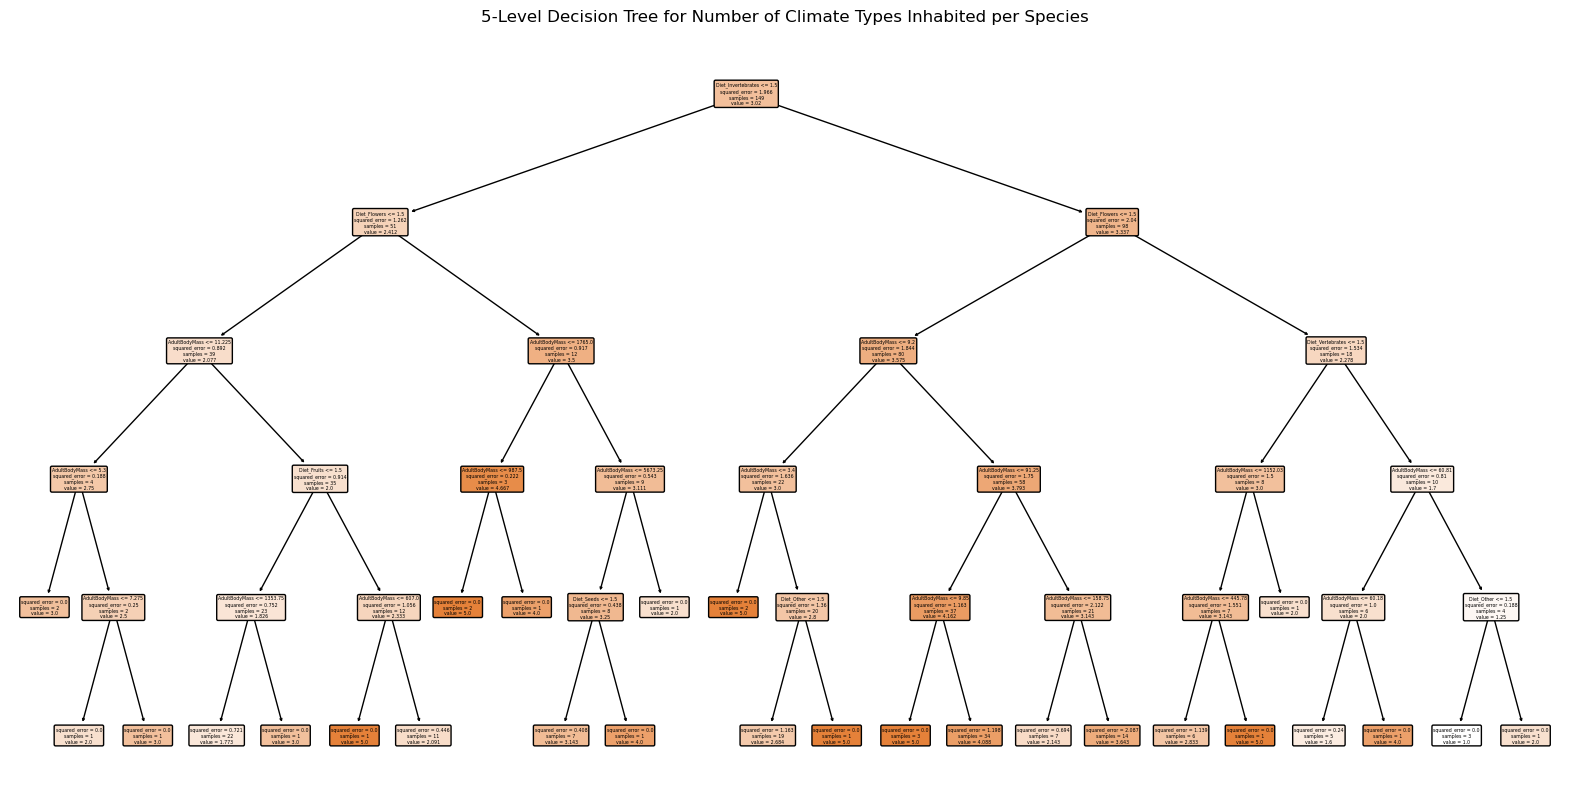

In [6]:
# Decision tree regressor
reg_tree = DecisionTreeRegressor(random_state=808,
                                max_depth=5)

# Train model
reg_tree.fit(X_train, y_train)

# Make predictions
y_pred = reg_tree.predict(X_test)

# Make plot
plt.figure(figsize=(20,10))
plot_tree(reg_tree,
         feature_names = X_train.columns,
         filled = True,
         rounded = True)
plt.title("5-Level Decision Tree for Number of Climate Types Inhabited per Species")
plt.show()

In [7]:
# evaluate mse
mse = mean_squared_error(y_test, y_pred)

# Print mse
print(f"Mean Squared Error: {mse:.3f}")

Mean Squared Error: 1.902


Based on the way this tree looks, what would you guess the most important variable to be?

Features generally towards the root and/or are split earlier have more importance, so I would expect the fir feature (at the very top) and the first feature resulting from the first split to have more importance (Diet_Invertebrates and Diet_Flowers). 

### Step 5: Random forest with hyperparameter tuning
Now we'll use a more sophisticated ensemble approach where we optimize the values of key hyperparameters that govern tree growth.

- Define a parameter grid that includes the follow parameters and values:
  -  (sqrt(p), 6, and no set #) of the number of features to try at each split
  -  (50, 100, 200) total trees (learners)
  -  a maximum tree depth of (3,4,5,6,7)
  -  (2,5,10) minimum samples per split
  -  (1,2,4) minimum samples per leaf
  
- Use `GridSearchCV` with 5-fold cross-validation and mse (`neg_mean_squared_error`) to find the best combination of parameter values
- Train the best estimator.

In [ ]:
# Parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_features': ['sqrt', 6, None],  # Features to consider at each split
    'max_depth': [3, 4, 5, 6, 7],  # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum samples needed to split a node
    'min_samples_leaf': [1, 2, 4]  # Minimum samples per leaf
}

# Initialize model
rf_reg = RandomForestRegressor(random_state=808)

# GridSearchCV 
grid_search = GridSearchCV(
    estimator=rf_reg, 
    param_grid=param_grid, 
    scoring='neg_mean_squared_error',
    cv=5  
)

# fit to training data
grid_search.fit(X_train, y_train)

# Get best estimator fromg grid search
best_rf = grid_search.best_estimator_

# Train model
best_rf.fit(X_train, y_train)

# Find and print best combo
print("Best Hyperparameters:", grid_search.best_params_)

### Step 6: Make predictions and evaluate random forest model
Use the optimized random forest model (`best_rf`) to predict the number of climates a species inhabits and analyze its performance.

- Use `best_rf` and `predict()` method on `X_test` to generate predictions
- Print the best set of parameter values using thte `best_params` method
- Compute and print the mse to evaluate model performance
- Extract feature importance from the trained random forest model
- Visualize feature importance using a bar plot

In [ ]:
# Use random forest model to predict on test set
y_pred_rf = best_rf.predict(X_test)

# Print best hyperparameter
print(f"Best hyperparameters:{grid_search.best_params_}")

# Calculate mse
mse_rf = mean_squared_error(y_test, y_pred_rf)

# Print mse
print(f"Random Forest model MSE: {mse_rf:.3f}")

# Extract feature importance from trained random forest model
feature_importance = best_rf.feature_importances_
feature_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
feature_df = feature_df.sort_values(by='Importance', ascending=False)

# Bar Plot Viz
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', 
            y='Feature', 
           data=feature_df)
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest Model")
plt.show()

Which model had better accuracy, the single tree or the ensemble.  Interpret which traits have the most influence on species' climate adaptability.

In [ ]:
# Print mse for single decision tree
print(f"KNN Decision Tree MSE: {mse:.2f}")

# Print mse for random forest (ensemble)
print(f"Random Forest model MSE: {mse_rf:.2f}")

The random forest model has a lower MSE of 1.51 compared to the decision tree's 1.90 MSE. This means that the random forest model makes smaller errors when making predictions. Additionally, these numbers make sense as the random forest model reduces overfitting by averaging many trees (as indicated ny n_estimators).